## RMF Analysis

RFM (Recency, Frequency, Monetary):
    
- **RECENCY (R)**: Time since last order
- **FREQUENCY (F)**: Total number of orders or average time between orders
- **MONETARY VALUE (M)**: Total or average order value

In [1]:
#IMPORT MODULES
import pandas as pd
import numpy as np
import datetime as dt

# visualization
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns; sns.set()

%matplotlib inline

In [2]:
# load the data
df_uk = pd.read_excel('UK_Data.xlsx',index_col=0)
df_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


Now, we'll go through the RFM analysis step by step.

### Recency

In [3]:
# get the reference date
ref = df_uk.InvoiceDate.dt.date.max()
ref

datetime.date(2011, 12, 9)

In [4]:
# convert InvoicdDate to date only
df_uk.InvoiceDate = df_uk.InvoiceDate.dt.date

In [5]:
df_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850,United Kingdom,20.34


In [6]:
recency = df_uk.groupby('CustomerID')['InvoiceDate'].\
          apply(lambda x: (ref - x.max()).days)

recency.head()

CustomerID
12747      2
12748      0
12749      3
12820      3
12821    214
Name: InvoiceDate, dtype: int64

### Frequency

We'll use the number of unique InvoiceNo per customer to calculate the frequency

In [7]:
freqency = df_uk.groupby('CustomerID')['InvoiceNo'].nunique() 
freqency.head()

CustomerID
12747     11
12748    200
12749      5
12820      4
12821      1
Name: InvoiceNo, dtype: int64

### Monetary

We'll use the total amount spent by customers over the period to get the Monetary table

In [8]:
monetary = df_uk.groupby('CustomerID')['Amount'].sum()
monetary.head()

CustomerID
12747     3073.41
12748    24891.45
12749     4032.98
12820      923.62
12821       92.72
Name: Amount, dtype: float64

Let's comebine the three RFM values and createRFM Dataframe

In [9]:
# Combine Recency and Frequency first
df_rf = recency.to_frame(name='Recency').\
              join(freqency.to_frame(name='Frequency'))

# then Montary
df_rfm = df_rf.join(monetary.to_frame(name='Monetary'))
df_rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12747,2,11,3073.41
12748,0,200,24891.45
12749,3,5,4032.98
12820,3,4,923.62
12821,214,1,92.72


In [10]:
# alternative (might be easier) way to create RFM dataframe
RMF = df_uk.groupby(['CustomerID']).agg({'InvoiceDate': lambda x: (ref - x.max()).days,    # GroupBy agg() method.
                                         'InvoiceNo': 'nunique', 'Amount': 'sum'})

RMF.rename(columns={'InvoiceDate': 'Recency',
                    'InvoiceNo': 'Frequency', 'Amount': 'Monetary'}, inplace=True)

RMF.head()

,Recency,Frequency,Monetary
CustomerID,,,
12747,2,11,3073.41
12748,0,200,24891.45
12749,3,5,4032.98
12820,3,4,923.62
12821,214,1,92.72


### RFM Scores

Now, let's assign scale scores. In order to do it, we can use quantiles,  you can think of this as dividing the data into 5 equally sized groups.

In [11]:
# Get 4 quantiles values
Quantiles = df_rfm.quantile(q=[0.2, 0.4, 0.6, 0.8])
Quantiles

,Recency,Frequency,Monetary
0.2,12.0,1.0,197.766
0.4,32.0,2.0,393.700
0.6,70.0,3.0,734.940
0.8,178.6,5.0,1576.588


In [12]:
Quantiles.Recency[0.4]

32.0

In [13]:
# First, we define a Rscore function to assign Recency scores

def Rscore(x, q, df):   # x=value, q=column, df=dataframe
    if x <= df[q][0.2]: # if x < first quantile value
        return 5        # return 5 as it is most recent.
    elif x <= df[q][0.4]:
        return 4
    elif x <= df[q][0.6]:
        return 3
    elif x <= df[q][0.8]:
        return 2
    else:
        return 1

In [14]:
# create a copy of the dataframe.
rfm_copy = df_rfm.copy()

In [15]:
# convert to R score
rfm_copy['Rscore'] = rfm_copy['Recency'].\
                        apply(Rscore, args=('Recency', Quantiles))
rfm_copy.head()

,Recency,Frequency,Monetary,Rscore
CustomerID,,,,
12747,2,11,3073.41,5
12748,0,200,24891.45,5
12749,3,5,4032.98,5
12820,3,4,923.62,5
12821,214,1,92.72,1


In [16]:
# Likewise, we can define a function to assign FM scores for each customer

def FMscore (x, q, df):        
    if x <= df[q][0.2]:     
        return 1             
    elif x <= df[q][0.4]:
        return 2
    elif x <= df[q][0.6]:
        return 3
    elif x <= df[q][0.8]:
        return 4
    else:
        return 5

In [17]:
rfm_copy['Fscore'] = rfm_copy['Frequency'].\
                    apply(FMscore,args=('Frequency',Quantiles))
rfm_copy['Mscore'] = rfm_copy['Monetary'].\
                    apply(FMscore,args=('Monetary',Quantiles))
rfm_copy.head()

,Recency,Frequency,Monetary,Rscore,Fscore,Mscore
CustomerID,,,,,,
12747,2,11,3073.41,5,5,5
12748,0,200,24891.45,5,5,5
12749,3,5,4032.98,5,4,5
12820,3,4,923.62,5,4,4
12821,214,1,92.72,1,1,1



Another way to get the RFM scores by using qcut() method.

In [18]:
r_range = range(5, 0, -1) #creating a reverse range to be used in labelling below.
f_range = range(1, 6)
m_range = range(1, 6)

In [19]:
rfm_another = df_rfm.copy()

rfm_another['Rscore'] = pd.qcut(rfm_another['Recency'], q=5, labels=r_range)

# as the first quantile in Frequency is 1, which will conflict with the lable 1, we have to use a different method;
# otherwise, we will get error message; but we might have that identical values go into different quantiles due to pre-ranking.
rfm_another['Fscore'] = pd.qcut(rfm_another['Frequency'].rank(method='first'), q=5, labels=f_range)
rfm_another['Mscore'] = pd.qcut(rfm_another['Monetary'], q=5, labels=m_range)

rfm_another.head()

,Recency,Frequency,Monetary,Rscore,Fscore,Mscore
CustomerID,,,,,,
12747,2,11,3073.41,5,5,5
12748,0,200,24891.45,5,5,5
12749,3,5,4032.98,5,4,5
12820,3,4,923.62,5,4,4
12821,214,1,92.72,1,1,1


In [20]:
# we use the avavage of R,F,and M scores for RFM score
rfm_copy['RFMscore'] = rfm_copy[['Rscore', 'Fscore', 
                                 'Mscore']].mean(axis=1)  

rfm_copy.head()

,Recency,Frequency,Monetary,Rscore,Fscore,Mscore,RFMscore
CustomerID,,,,,,,
12747,2,11,3073.41,5,5,5,5.000000
12748,0,200,24891.45,5,5,5,5.000000
12749,3,5,4032.98,5,4,5,4.666667
12820,3,4,923.62,5,4,4,4.333333
12821,214,1,92.72,1,1,1,1.000000


Now, depending on what values most to your business, you can segement customers into different groups, for example:

- Frequent buyers
- Big spenders
- Plantium customers
- Gold customers, etc.

In [21]:
# we define a function to segement customers

def segment(df):
    if df.RFMscore <= 1:
        return 'Basic'
    elif df.RFMscore <= 2:
        return 'Bronze'
    elif df.RFMscore <= 3:
        return 'Silver'
    elif df.RFMscore <= 4:
        return 'Gold'
    elif df.RFMscore <= 4.5:
        return 'Platinum'
    else:
        return 'Diamond'

In [22]:
rfm_copy['LoyaltyGroup'] = rfm_copy.apply(segment, axis=1)
rfm_copy.head(n=10)

,Recency,Frequency,Monetary,Rscore,Fscore,Mscore,RFMscore,LoyaltyGroup
CustomerID,,,,,,,,
12747,2,11,3073.41,5,5,5,5.000000,Diamond
12748,0,200,24891.45,5,5,5,5.000000,Diamond
12749,3,5,4032.98,5,4,5,4.666667,Diamond
12820,3,4,923.62,5,4,4,4.333333,Platinum
12821,214,1,92.72,1,1,1,1.000000,Basic
12822,70,2,806.08,3,2,4,3.000000,Silver
12824,59,1,397.12,3,1,3,2.333333,Silver
12826,2,7,1460.80,5,5,4,4.666667,Diamond
12827,5,3,430.15,5,3,3,3.666667,Gold


Let's have a look at how many customers in each group:

In [23]:
rfm_score = rfm_copy.reset_index()
rfm_score.groupby('LoyaltyGroup')['CustomerID'].\
                 count().sort_values(ascending=False)

LoyaltyGroup
Bronze      1081
Silver       911
Gold         748
Diamond      555
Basic        270
Platinum     253
Name: CustomerID, dtype: int64

## Clustering Algorithms

We will use one of the most popular ML algorithms for customer segementation: **K-Means**. However, KMeans assumes symmetric distribution. We will plot the data and check:

In [24]:
from sklearn.cluster import KMeans

In [25]:
df_rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12747,2,11,3073.41
12748,0,200,24891.45
12749,3,5,4032.98
12820,3,4,923.62
12821,214,1,92.72


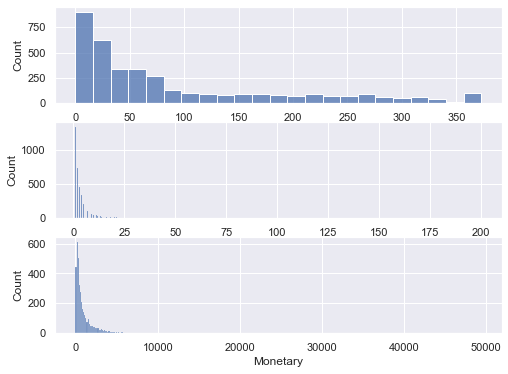

In [26]:
fig, axs = plt.subplots(3, figsize=(8,6))
sns.histplot(df_rfm['Recency'], ax=axs[0])
sns.histplot(df_rfm['Frequency'], ax=axs[1])
sns.histplot(df_rfm['Monetary'], ax=axs[2]);

From the above figures, we can see that the data are right-skewed. We need to tranform the data before feeding them into the model.

#### Feature scaling

In [28]:
# apply log traformation
df_rfm_log = np.log(df_rfm)

Ooops, we got some zero values in the data.

In [29]:
# let's check where those zeros exist in the data.
df_rfm[df_rfm.values == 0]  # only in the Recency values.

,Recency,Frequency,Monetary
CustomerID,,,
12748,0,200,24891.45
12985,0,2,1048.82
13069,0,24,3593.52
13113,0,24,5810.54
13426,0,10,3098.12
14051,0,23,11962.51
14422,0,6,3990.84
14441,0,4,1712.89
14446,0,4,998.90


In [30]:
# we can add 1 to the value manually or use np.log1p()
df_rfm_log = np.log1p(df_rfm)
df_rfm_log.describe()

,Recency,Frequency,Monetary
count,3818.000000,3818.000000,3818.000000
mean,3.802618,1.328704,6.322770
std,1.376123,0.663912,1.221246
min,0.000000,0.693147,1.064711
25%,2.890372,0.693147,5.494511
50%,3.931826,1.098612,6.312566
75%,4.976734,1.609438,7.163308
max,5.924256,5.303305,10.807509


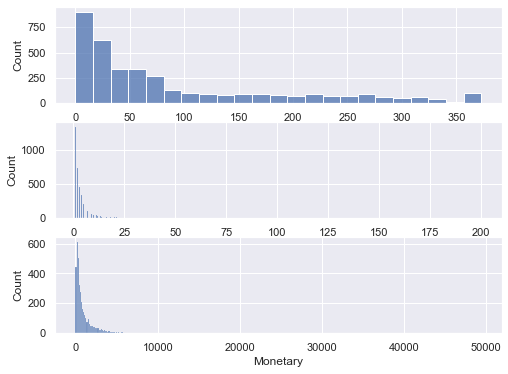

In [31]:
fig, axs = plt.subplots(3, figsize=(8,6))
sns.histplot(df_rfm['Recency'], ax=axs[0])
sns.histplot(df_rfm['Frequency'], ax=axs[1])
sns.histplot(df_rfm['Monetary'], ax=axs[2]);

It is better than the inital data though not perfect. 
Now, we standardize features by applying StandardScaler()

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#fit and then tranform the data
df_rfm_scaled = scaler.fit_transform(df_rfm_log) 

#convert output to dataframe
df_rfm_scaled = pd.DataFrame(data=df_rfm_scaled,
                             index=df_rfm.index,
                             columns=df_rfm.columns) 
df_rfm_scaled.describe()

,Recency,Frequency,Monetary
count,3.818000e+03,3.818000e+03,3.818000e+03
mean,3.161395e-17,2.881113e-16,-5.579612e-16
std,1.000131e+00,1.000131e+00,1.000131e+00
min,-2.763645e+00,-9.574159e-01,-4.306053e+00
25%,-6.629968e-01,-9.574159e-01,-6.782973e-01
50%,9.390510e-02,-3.466148e-01,-8.356783e-03
75%,8.533175e-01,4.229036e-01,6.883528e-01
max,1.541952e+00,5.987422e+00,3.672747e+00


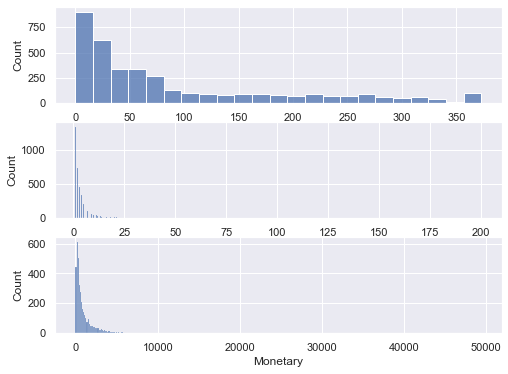

In [33]:
fig, axs = plt.subplots(3, figsize=(8,6))
sns.histplot(df_rfm['Recency'], ax=axs[0])
sns.histplot(df_rfm['Frequency'], ax=axs[1])
sns.histplot(df_rfm['Monetary'], ax=axs[2]);

All the data have been standardized now. You could do further on Frequncy since it is still skewed. However, we just stop here for this example.

#### Applying K-Means clustering

In [34]:
#let's start with 4 clusters first
kmeans = KMeans(n_clusters=4, random_state=42) 
clusters = kmeans.fit_predict(df_rfm_scaled)
cluster_center = kmeans.cluster_centers_
cluster_lable = kmeans.labels_
cluster_center

array([[ 0.04176226,  0.38200412,  0.55742072],
       [ 0.93583565, -0.77807665, -0.79033255],
       [-1.30643564,  1.65800787,  1.36764984],
       [-0.69785053, -0.49681166, -0.4890608 ]])

#### Visualising clusters

<IPython.core.display.Javascript object>


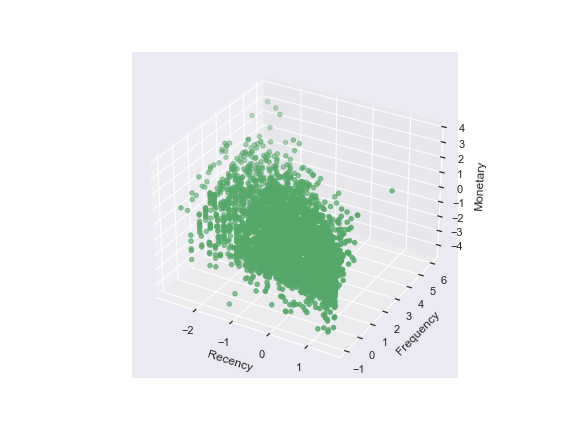

In [35]:
# plot a 3D figure without clusters
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook 

fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
ax.scatter3D(df_rfm_scaled.Recency, df_rfm_scaled.Frequency,
             df_rfm_scaled.Monetary, c='g')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');

<IPython.core.display.Javascript object>


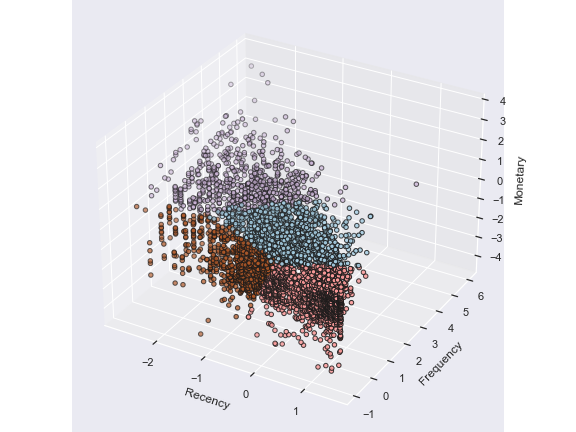

In [36]:
#3D scatter plot with 4 clusters
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig)

ax.scatter(df_rfm_scaled.Recency, df_rfm_scaled.Frequency,
           df_rfm_scaled.Monetary, c=cluster_lable, 
           edgecolor='k', cmap='Paired')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('Four Clusters', fontsize=15);

#### Determining the right number of clusters

First, let's see how we can use the Elbow method to select the right number of clusters                                         

In [37]:
inertia = []  # create an empty list
for n_clusters in range(1, 10):
    kmeans = KMeans(n_clusters=n_clusters,random_state=42)
    kmeans.fit(df_rfm_scaled)
    # append the inertia values from each model to the list
    inertia.append(kmeans.inertia_)

D:\APP\CONDA\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=15.
  warnings.warn(


**Note**: Inertia is the sum of squared distances of datapoints to their closest cluster centre.

<IPython.core.display.Javascript object>


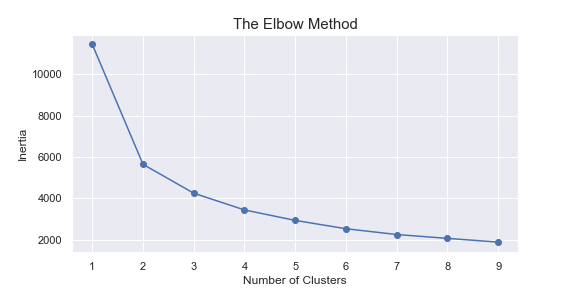

In [46]:
df_inertia = pd.DataFrame({'Cluster': range(1, 10), 
                           'Inertia': inertia})
plt.figure(figsize=(8, 4))
plt.plot(df_inertia.Cluster, df_inertia.Inertia, '-o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method', fontsize=15);

Looking at the Elbow plot above, it seems that 2 or 3 is where the elbow starts. Let's choose 3 clusters and fit the model. 

<IPython.core.display.Javascript object>


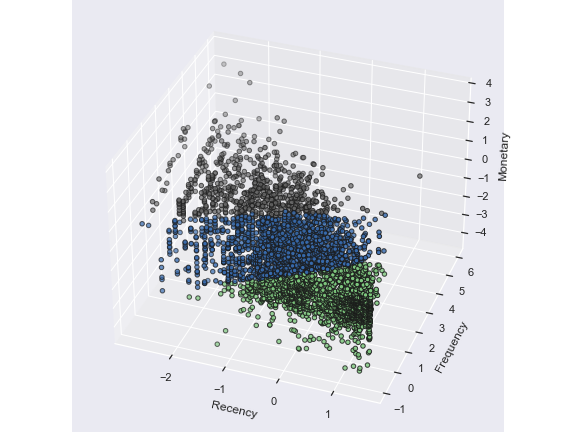

In [39]:
# train kmeans model
kmeans = KMeans(n_clusters=3,random_state=42)
clusters = kmeans.fit_predict(df_rfm_scaled)
cluster_lable = kmeans.labels_

# 3D scatter plot with 3 clusters
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig)
ax.scatter(df_rfm_scaled.Recency, df_rfm_scaled.Frequency,
           df_rfm_scaled.Monetary, c=cluster_lable, 
           edgecolor='k', cmap='Accent')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('Three Clusters', fontsize=15);


However, note that the elbow method is sometimes ambiguous. An alternative is the average silhouette method (Kaufman and Rousseeuw,1990)

In [40]:
from sklearn.metrics import silhouette_score

**Note**: silhouette coefficients has a range of [-1, 1]. Closer to 1 means better.

In [41]:
# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed clusters

for n_clusters in range(2, 20):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(df_rfm_scaled)
    clusters = kmeans.predict(df_rfm_scaled)
    sil_avg = silhouette_score(df_rfm_scaled, clusters)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", sil_avg)

For n_clusters = 2 The average silhouette_score is : 0.4337451049965267
For n_clusters = 3 The average silhouette_score is : 0.340529381288137
For n_clusters = 4 The average silhouette_score is : 0.3333115356295477
For n_clusters = 5 The average silhouette_score is : 0.3112774723320785
For n_clusters = 6 The average silhouette_score is : 0.29398494681694687
For n_clusters = 7 The average silhouette_score is : 0.28686571970475655
For n_clusters = 8 The average silhouette_score is : 0.28672610534596366
For n_clusters = 9 The average silhouette_score is : 0.28801801885710365
For n_clusters = 10 The average silhouette_score is : 0.2941041384796828
For n_clusters = 11 The average silhouette_score is : 0.2843928088198798
For n_clusters = 12 The average silhouette_score is : 0.2763225685785894
For n_clusters = 13 The average silhouette_score is : 0.2807078366621835
For n_clusters = 14 The average silhouette_score is : 0.28031162230694046
For n_clusters = 15 The average silhouette_score is : 0

Clearly 2 clusters gives the highest silhouette score

<IPython.core.display.Javascript object>


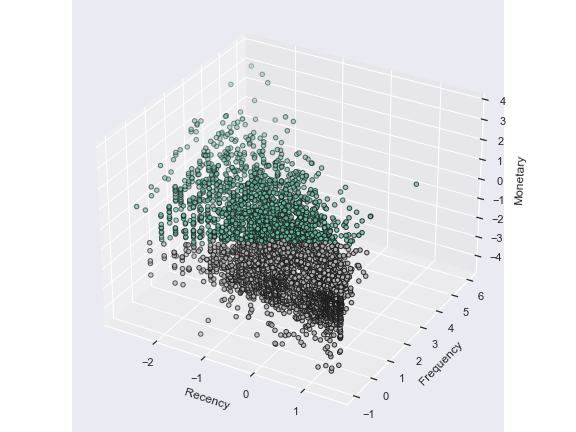

In [42]:
# set n_clsuters to 2
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(df_rfm_scaled)
cluster_lable = kmeans.labels_

# 3D scatter plot with 2 clusters
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig)

ax.scatter(df_rfm_scaled.Recency, df_rfm_scaled.Frequency,
           df_rfm_scaled.Monetary, c=cluster_lable, edgecolor='k', cmap='Set2')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('Two Clusters', fontsize=15);

<IPython.core.display.Javascript object>


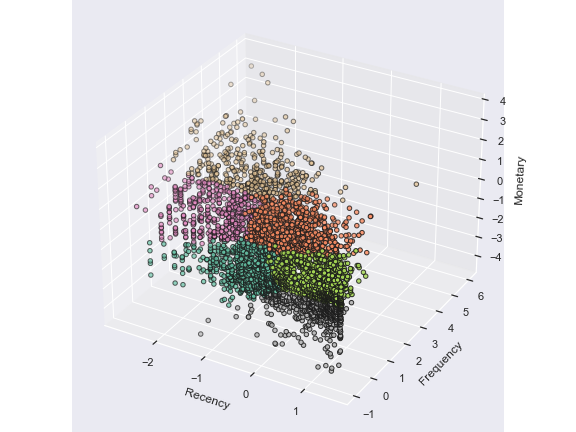

In [43]:
# train kmeans model with 6 clusters
kmeans = KMeans(n_clusters=6,random_state=42)
clusters = kmeans.fit_predict(df_rfm_scaled)
cluster_lable = kmeans.labels_

# 3D scatter plot with 3 clusters
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig)

ax.scatter(df_rfm_scaled.Recency, df_rfm_scaled.Frequency,
           df_rfm_scaled.Monetary, c=cluster_lable, 
           edgecolor='k', cmap='Set2')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('Six Clusters', fontsize=15);

**Conclusion**: Since the data are not clearly differetiated in the 3D plot, I would argue that either 2 or 6 clusters would be fine, depending on how you want to categorise your customers into different groups.